# Prerequisites

In [9]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime, timedelta
import numpy as np

is_on_colab = False

In [10]:
# Optiional: Connect to Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    timenow = datetime.now()+timedelta(hours=-7)
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone")
    is_on_colab = True
else:
    print('Running on Local')
    timenow = datetime.now()
    is_on_colab = False

timenow_str = f"{timenow.hour:02d}{timenow.minute:02d}{timenow.month:02d}{timenow.day:02d}"

Running on Local


In [11]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import Trainer
importlib.reload(Trainer)

utils.fix_random_seed(1127)#Hypers.Config.seed)

if is_on_colab:
  Hypers.Config.base_path = os.getcwd()
  Hypers.Config.data_path = os.path.join(Hypers.Config.base_path, "data")
  Hypers.Config.model_path = os.path.join(Hypers.Config.base_path, "model")
  Hypers.Config.log_path = os.path.join(Hypers.Config.base_path, "log")

print(f"{Hypers.Config.base_path=}")
print(f"{Hypers.Config.data_path=}")
print(f"{Hypers.Config.model_path=}")
print(f"{Hypers.Config.log_path=}")

Hypers.Config.base_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone'
Hypers.Config.data_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\data'
Hypers.Config.model_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\model'
Hypers.Config.log_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\log'


In [12]:
suffix = "US"
window_size = 4

In [4]:
import CompustatExtractor
importlib.reload(CompustatExtractor)
from CompustatExtractor import CompustatExtractor

dataset_path = os.path.join(Hypers.Config.data_path, "WRDS", f"dataset_{suffix}.pkl")
dataset_noCPI_path = os.path.join(Hypers.Config.data_path, "WRDS", f"dataset_{suffix}_noCPI.pkl")

features = CompustatExtractor.process_compustat_features(
	os.path.join(Hypers.Config.data_path, "WRDS", f"features_{suffix}.csv"),
	save=False,
	filestem=f"features_{suffix}",
	add_cpi=True
)

concatenate_features = CompustatExtractor.concatenate_features(features, k=window_size)

ratings = CompustatExtractor.process_compustat_ratings(
	os.path.join(Hypers.Config.data_path, "WRDS", f"ratings_{suffix}.csv"),
	save=False,
	filestem=f"ratings_{suffix}"
)

merged_dict = CompustatExtractor.merge_input_output_dicts(
	concatenate_features,
	ratings,
	save=True,
	filestem=f"dataset_{suffix}"
)


input_dict: 2510
output_dict: 1151
merged_dict: 775


### Data preprocessing

In [13]:
import itertools

preprocessing_options = [
    {"standardize": True, "power_transformation": True},
    {"standardize": True, "power_transformation": False},
]

architecture_options = [
    {"dropout": True, "batch_norm": True, "num_conv_layers": 2},
    {"dropout": True, "batch_norm": True, "num_conv_layers": 1},
    {"dropout": False, "batch_norm": False, "num_conv_layers": 2},
    {"dropout": False, "batch_norm": False, "num_conv_layers": 1},
]

hyperparameter_options = list(itertools.product(
    [0, 1e-4], #reg decay
    [nn.ReLU, nn.SiLU] #activation function
))

# Conv1d

In [1]:
import ConvDataset
importlib.reload(ConvDataset)
import ConvModel
importlib.reload(ConvModel)

model_type = "Conv"

NameError: name 'importlib' is not defined

In [15]:
def apply_scaler(data_dict, scaler):
    scaled_dict = {}
    for company, data in data_dict.items():
        scaled_dict[company] = {}
        for period, (features, label, label_normalized) in data.items():
            features = scaler.transform(features.reshape(1, -1)).reshape(features.shape)
            scaled_dict[company][period] = (features, label, label_normalized)
    return scaled_dict

In [16]:
from sklearn.preprocessing import PowerTransformer

def apply_power_transformation(data_dict):
    transformer = PowerTransformer(method='yeo-johnson')
    all_features = []
    for company, data in data_dict.items():
        for period, (features, label, label_normalized) in data.items():
            features = np.clip(features, a_min=-1e6, a_max=1e6)
            all_features.append(features.reshape(1, -1))
    
    transformer.fit(np.vstack(all_features))
    
    transformed_dict = {}
    for company, data in data_dict.items():
        transformed_dict[company] = {}
        for period, (features, label, label_normalized) in data.items():
            transformed_features = transformer.transform(features.reshape(1, -1)).reshape(features.shape)
            transformed_dict[company][period] = (transformed_features, label, label_normalized)
    
    return transformed_dict

In [9]:
from sklearn.preprocessing import StandardScaler

results_over_threshold = []
threshold = 0.5
best_history = []
best_acc = 0

for preprocess in preprocessing_options:
    merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"dataset_{suffix}.pkl"))
        
    if preprocess["standardize"]:
        scaler = StandardScaler()
        all_features = []
        for company, data in merged_dict.items():
            for period, (features, label, label_normalized) in data.items():
                all_features.append(features.reshape(1, -1))
        scaler.fit(np.vstack(all_features))
        
        merged_dict = apply_scaler(merged_dict, scaler)
    
    if preprocess["power_transformation"]:        
        merged_dict = apply_power_transformation(merged_dict)

    train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True, suffix=suffix)
    
    for architecture in architecture_options:
        for reg_param, activation_fn in hyperparameter_options:
            input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
            model = ConvModel.ConvModel(feature_size=input_size,
                                        num_conv_layers=architecture["num_conv_layers"],
                                        dropout=architecture["dropout"],
                                        batch_norm=architecture["batch_norm"],
                                        activation_fn=activation_fn)
            
            train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
            valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)
            
            train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
            valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
            
            criterion = nn.MSELoss(reduction="sum")
            optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate, weight_decay=reg_param)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            trainer = Trainer.Trainer(model=model,
                                      criterion=criterion,
                                      optimizer=optimizer,
                                      device=device,
                                      train_loader=train_loader,
                                      valid_loader=valid_loader,
                                      model_type=model_type)
            
            train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
            print(f"Combination: Preprocess={preprocess}, Architecture={architecture}, Reg Param={reg_param}, Activation={activation_fn.__name__}\n-> Valid Accuracy: {valid_accuracy[-1]}")
            
            if valid_accuracy[-1] > threshold:
                results_over_threshold.append({
                    "preprocess": preprocess,
                    "architecture": architecture,
                    "reg_param": reg_param,
                    "activation_fn": activation_fn.__name__,
                    "valid_accuracy": valid_accuracy[-1]
                })
            if best_acc < valid_accuracy[-1]:
                best_history = [train_loss, train_accuracy, valid_loss, valid_accuracy]

            # utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy)


Vaild Epoch 99: 100%|██████████| 100/100 [04:51<00:00,  2.91s/it, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.5102399063779989


Vaild Epoch 99: 100%|██████████| 100/100 [05:09<00:00,  3.10s/it, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.5157987126974839


Vaild Epoch 99: 100%|██████████| 100/100 [04:43<00:00,  2.84s/it, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.49151550614394385


Vaild Epoch 99: 100%|██████████| 100/100 [04:47<00:00,  2.87s/it, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5315974253949678


Vaild Epoch 99: 100%|██████████| 100/100 [03:47<00:00,  2.27s/it, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.49853715623171446


Vaild Epoch 99: 100%|██████████| 100/100 [03:47<00:00,  2.28s/it, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.5149210064365126


Vaild Epoch 99: 100%|██████████| 100/100 [03:47<00:00,  2.27s/it, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.4906377998829725


Vaild Epoch 99: 100%|██████████| 100/100 [03:49<00:00,  2.29s/it, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5201872440023405


Vaild Epoch 99: 100%|██████████| 100/100 [03:50<00:00,  2.30s/it, Loss: 0.008]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4596255119953189


Vaild Epoch 99: 100%|██████████| 100/100 [03:53<00:00,  2.34s/it, Loss: 0.008]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.46342890579286133


Vaild Epoch 99: 100%|██████████| 100/100 [03:55<00:00,  2.36s/it, Loss: 0.008]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.46489174956114687


Vaild Epoch 99: 100%|██████████| 100/100 [04:02<00:00,  2.42s/it, Loss: 0.008]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.46459918080748974


Vaild Epoch 99: 100%|██████████| 100/100 [03:14<00:00,  1.95s/it, Loss: 0.008]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.449093036863663


Vaild Epoch 99: 100%|██████████| 100/100 [03:16<00:00,  1.96s/it, Loss: 0.008]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4605032182562902


Vaild Epoch 99: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it, Loss: 0.009]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.4534815681685196


Vaild Epoch 99: 100%|██████████| 100/100 [03:17<00:00,  1.98s/it, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4713282621416033


Vaild Epoch 99: 100%|██████████| 100/100 [04:40<00:00,  2.81s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4302721088435374


Vaild Epoch 99: 100%|██████████| 100/100 [04:42<00:00,  2.83s/it, Loss: 0.011]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.43565759637188206


Vaild Epoch 99: 100%|██████████| 100/100 [04:43<00:00,  2.83s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.45351473922902497


Vaild Epoch 99: 100%|██████████| 100/100 [04:46<00:00,  2.86s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.45975056689342403


Vaild Epoch 99: 100%|██████████| 100/100 [03:45<00:00,  2.25s/it, Loss: 0.009]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4574829931972789


Vaild Epoch 99: 100%|██████████| 100/100 [03:47<00:00,  2.27s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4260204081632653


Vaild Epoch 99: 100%|██████████| 100/100 [03:48<00:00,  2.28s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.43339002267573695


Vaild Epoch 99: 100%|██████████| 100/100 [03:50<00:00,  2.31s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.44359410430839


Vaild Epoch 99: 100%|██████████| 100/100 [03:51<00:00,  2.31s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4852607709750567


Vaild Epoch 99: 100%|██████████| 100/100 [03:54<00:00,  2.35s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4688208616780045


Vaild Epoch 99: 100%|██████████| 100/100 [03:54<00:00,  2.34s/it, Loss: 0.009]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.49348072562358275


Vaild Epoch 99: 100%|██████████| 100/100 [03:57<00:00,  2.37s/it, Loss: 0.009]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5045351473922902


Vaild Epoch 99: 100%|██████████| 100/100 [03:10<00:00,  1.91s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4917800453514739


Vaild Epoch 99: 100%|██████████| 100/100 [03:13<00:00,  1.93s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.49121315192743764


Vaild Epoch 99: 100%|██████████| 100/100 [03:13<00:00,  1.93s/it, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.48667800453514737


Vaild Epoch 99: 100%|██████████| 100/100 [03:14<00:00,  1.95s/it, Loss: 0.010]

Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4951814058956916


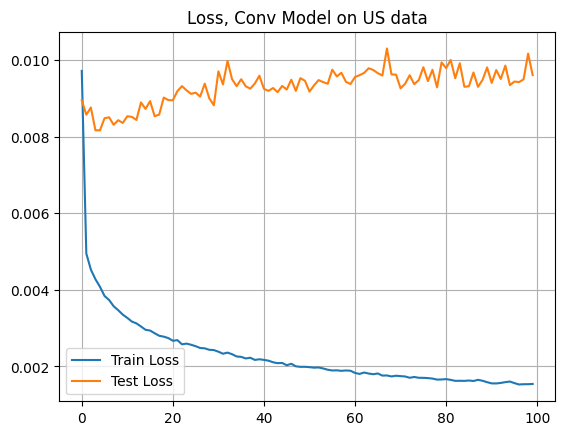

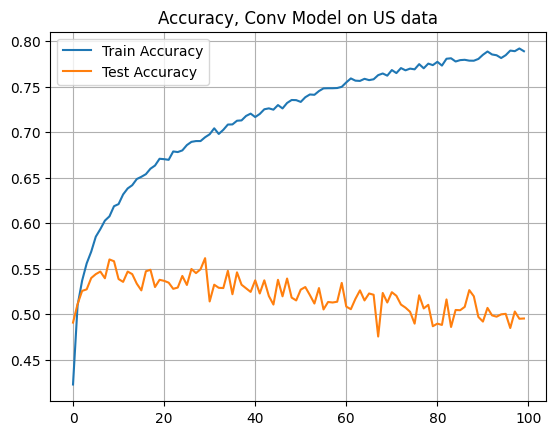

In [10]:
utils.plot_graph(*best_history, identifier="Conv Model on US data")


In [13]:
train_loss, train_accuracy, valid_loss, valid_accuracy = best_history
print(train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1])

0.0015425056622869484 0.7890167136965487 0.009603959942751832 0.4951814058956916


In [ ]:
import pickle

with open('result_US1.pkl', 'wb') as file:
    pickle.dump(results_over_threshold, file)

In [17]:
preprocessing_options = [
    {"standardize": False, "power_transformation": True},
    {"standardize": False, "power_transformation": False},
]

In [18]:
from sklearn.preprocessing import StandardScaler

results_over_threshold = []
threshold = 0
best_history = []
best_acc = 0

for preprocess in preprocessing_options:
    merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"dataset_{suffix}.pkl"))
        
    if preprocess["standardize"]:
        scaler = StandardScaler()
        all_features = []
        for company, data in merged_dict.items():
            for period, (features, label, label_normalized) in data.items():
                all_features.append(features.reshape(1, -1))
        scaler.fit(np.vstack(all_features))
        
        merged_dict = apply_scaler(merged_dict, scaler)
    
    if preprocess["power_transformation"]:        
        merged_dict = apply_power_transformation(merged_dict)

    train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True, suffix=suffix)
    
    for architecture in architecture_options:
        for reg_param, activation_fn in hyperparameter_options:
            input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
            model = ConvModel.ConvModel(feature_size=input_size,
                                        num_conv_layers=architecture["num_conv_layers"],
                                        dropout=architecture["dropout"],
                                        batch_norm=architecture["batch_norm"],
                                        activation_fn=activation_fn)
            
            train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
            valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)
            
            train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
            valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
            
            criterion = nn.MSELoss(reduction="sum")
            optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate, weight_decay=reg_param)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            trainer = Trainer.Trainer(model=model,
                                      criterion=criterion,
                                      optimizer=optimizer,
                                      device=device,
                                      train_loader=train_loader,
                                      valid_loader=valid_loader,
                                      model_type=model_type)
            
            train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
            print(f"Combination: Preprocess={preprocess}, Architecture={architecture}, Reg Param={reg_param}, Activation={activation_fn.__name__}\n-> Valid Accuracy: {valid_accuracy[-1]}")
            
            if valid_accuracy[-1] > threshold:
                results_over_threshold.append({
                    "preprocess": preprocess,
                    "architecture": architecture,
                    "reg_param": reg_param,
                    "activation_fn": activation_fn.__name__,
                    "valid_accuracy": valid_accuracy[-1]
                })
            if best_acc < valid_accuracy[-1]:
                best_history = [train_loss, train_accuracy, valid_loss, valid_accuracy]

            # utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy)


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
Vaild Epoch 99: 100%|██████████| 100/100 [04:31<00:00,  2.72s/it, Loss: 0.006]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.5099473376243417


Vaild Epoch 99: 100%|██████████| 100/100 [04:32<00:00,  2.73s/it, Loss: 0.006]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.521650087770626


Vaild Epoch 99: 100%|██████████| 100/100 [04:33<00:00,  2.73s/it, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.5029256875365711


Vaild Epoch 99: 100%|██████████| 100/100 [04:36<00:00,  2.77s/it, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5441778818022235


Vaild Epoch 99: 100%|██████████| 100/100 [03:37<00:00,  2.17s/it, Loss: 0.006]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.49853715623171446


Vaild Epoch 99: 100%|██████████| 100/100 [03:39<00:00,  2.20s/it, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.5140433001755412


Vaild Epoch 99: 100%|██████████| 100/100 [03:40<00:00,  2.21s/it, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.5099473376243417


Vaild Epoch 99: 100%|██████████| 100/100 [03:42<00:00,  2.22s/it, Loss: 0.006]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5219426565242832


Vaild Epoch 99: 100%|██████████| 100/100 [03:42<00:00,  2.22s/it, Loss: 0.008]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4663545933294324


Vaild Epoch 99: 100%|██████████| 100/100 [03:44<00:00,  2.25s/it, Loss: 0.007]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4669397308367466


Vaild Epoch 99: 100%|██████████| 100/100 [03:44<00:00,  2.25s/it, Loss: 0.008]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.4596255119953189


Vaild Epoch 99: 100%|██████████| 100/100 [03:48<00:00,  2.28s/it, Loss: 0.008]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4783499122293739


Vaild Epoch 99: 100%|██████████| 100/100 [03:02<00:00,  1.83s/it, Loss: 0.008]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4531889994148625


Vaild Epoch 99: 100%|██████████| 100/100 [03:05<00:00,  1.85s/it, Loss: 0.008]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.46284376828554713


Vaild Epoch 99: 100%|██████████| 100/100 [03:05<00:00,  1.85s/it, Loss: 0.007]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.4707431246342891


Vaild Epoch 99: 100%|██████████| 100/100 [03:06<00:00,  1.87s/it, Loss: 0.007]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4809830310122879


Vaild Epoch 99: 100%|██████████| 100/100 [04:30<00:00,  2.71s/it, Loss: 0.010]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4379251700680272


Vaild Epoch 99: 100%|██████████| 100/100 [04:35<00:00,  2.75s/it, Loss: 0.010]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.47392290249433106


Vaild Epoch 99: 100%|██████████| 100/100 [04:35<00:00,  2.75s/it, Loss: 0.014]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.34750566893424034


Vaild Epoch 99: 100%|██████████| 100/100 [04:37<00:00,  2.78s/it, Loss: 0.011]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4373582766439909


Vaild Epoch 99: 100%|██████████| 100/100 [03:38<00:00,  2.19s/it, Loss: 0.010]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4217687074829932


Vaild Epoch 99: 100%|██████████| 100/100 [03:40<00:00,  2.21s/it, Loss: 0.010]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.44727891156462585


Vaild Epoch 99: 100%|██████████| 100/100 [03:41<00:00,  2.22s/it, Loss: 0.013]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.3492063492063492


Vaild Epoch 99: 100%|██████████| 100/100 [03:43<00:00,  2.24s/it, Loss: 0.011]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.44302721088435376


Vaild Epoch 99: 100%|██████████| 100/100 [03:45<00:00,  2.26s/it, Loss: 0.010]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4441609977324263


Vaild Epoch 99: 100%|██████████| 100/100 [03:53<00:00,  2.34s/it, Loss: 0.010]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.49489795918367346


Vaild Epoch 99: 100%|██████████| 100/100 [03:49<00:00,  2.29s/it, Loss: 0.009]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.5357142857142857


Vaild Epoch 99: 100%|██████████| 100/100 [03:55<00:00,  2.36s/it, Loss: 0.010]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.47732426303854875


Vaild Epoch 99: 100%|██████████| 100/100 [03:06<00:00,  1.86s/it, Loss: 0.009]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.49404761904761907


Vaild Epoch 99: 100%|██████████| 100/100 [03:11<00:00,  1.92s/it, Loss: 0.009]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4943310657596372


Vaild Epoch 99: 100%|██████████| 100/100 [03:07<00:00,  1.87s/it, Loss: 0.009]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.5099206349206349


Vaild Epoch 99: 100%|██████████| 100/100 [03:12<00:00,  1.92s/it, Loss: 0.009]

Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4628684807256236


In [19]:
import pickle

with open('result_US2.pkl', 'wb') as file:
    pickle.dump(results_over_threshold, file)

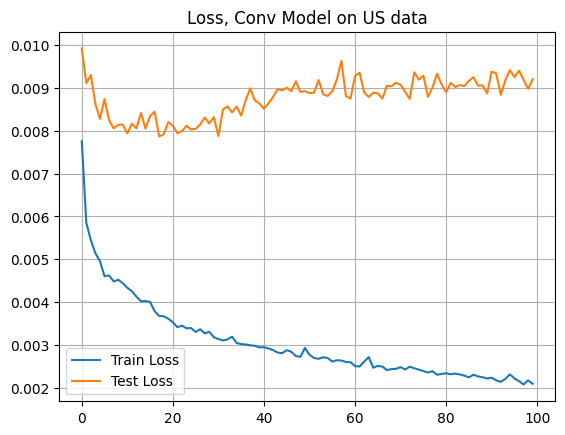

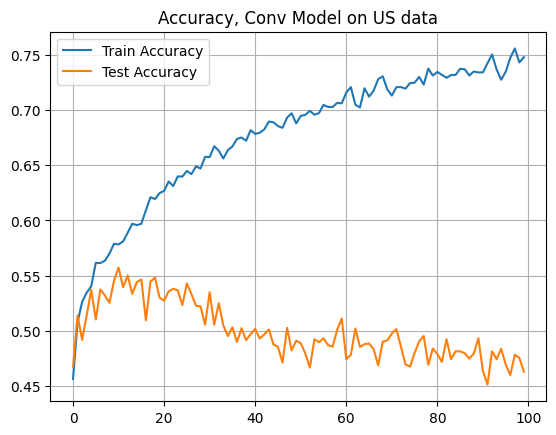

In [20]:
utils.plot_graph(*best_history, identifier="Conv Model on US data")


In [21]:
train_loss, train_accuracy, valid_loss, valid_accuracy = best_history
print(train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1])

0.0020889092335677874 0.7480645394689242 0.009206797381706721 0.4628684807256236


In [22]:
import pickle

with open('result_US1.pkl', 'rb') as file:
    results_over_threshold = pickle.load(file)

with open('result_US2.pkl', 'rb') as file:
    results_over_threshold += pickle.load(file)\



In [23]:
sorted_results = sorted(results_over_threshold, key=lambda x: x["valid_accuracy"], reverse=True)

top_10_results = sorted_results[:10]

for i, result in enumerate(top_10_results, 1):
    print(f"  Preprocess: {result['preprocess']}")
    print(f"  Architecture: {result['architecture']}")
    print(f"  Regularization Parameter: {result['reg_param']}")
    print(f"  Activation Function: {result['activation_fn']}")
    print(f"  Validation Accuracy: {result['valid_accuracy']}")
    print()

  Preprocess: {'standardize': False, 'power_transformation': True}
  Architecture: {'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}
  Regularization Parameter: 0.0001
  Activation Function: SiLU
  Validation Accuracy: 0.5441778818022235

  Preprocess: {'standardize': False, 'power_transformation': False}
  Architecture: {'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}
  Regularization Parameter: 0.0001
  Activation Function: ReLU
  Validation Accuracy: 0.5357142857142857

  Preprocess: {'standardize': True, 'power_transformation': True}
  Architecture: {'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}
  Regularization Parameter: 0.0001
  Activation Function: SiLU
  Validation Accuracy: 0.5315974253949678

  Preprocess: {'standardize': False, 'power_transformation': True}
  Architecture: {'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}
  Regularization Parameter: 0.0001
  Activation Function: SiLU
  Validation Accuracy: 0.5219426565242832

  

# -----------------

In [ ]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")
print(suffix)

len(train_dict)=283 len(test_dict)=59
Ret


In [ ]:
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
print(f"{input_size=}")

input_size=38


Vaild Epoch 199: 100%|██████████| 200/200 [05:10<00:00,  1.55s/it, Loss: 0.011]


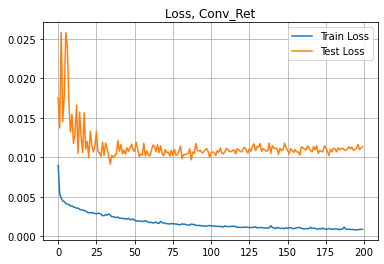

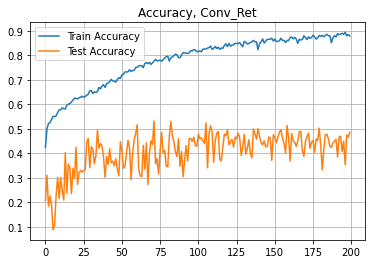

In [ ]:
train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)

model = ConvModel.ConvModel(feature_size=input_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader,
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

# Infer

In [ ]:
import Inferencer
importlib.reload(Inferencer)

<module 'Inferencer' from '/Users/Ryo/Desktop/UCLA/PNC_Capstone/Inferencer.py'>

In [ ]:
import RegressionDataset
importlib.reload(RegressionDataset)
import RegressionModel
importlib.reload(RegressionModel)

test_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=False, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)
inferencer = Inferencer.Inferencer(model=model, test_loader=test_loader, device=device)
predictions, turths, accuracy, diff_counter = inferencer.infer()

In [ ]:
nums = 10
print(predictions[:nums])
print(turths[:nums])

tensor([5., 5., 4., 4., 4., 4., 4., 4., 3., 4.])
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])


In [ ]:
print(diff_counter)

Counter({0.0: 666, 1.0: 549, 2.0: 109, 5.0: 25, 4.0: 8, 3.0: 7, 6.0: 5})


In [ ]:
total_count = sum(diff_counter.values())
print(f"{total_count=}")

total_count=1369


In [ ]:
accumulated_count = []

for i in range(0, 33):
    count = diff_counter[i]
    if i==0:
        accumulated_count.append(count)
        continue
    accumulated_count.append(accumulated_count[-1]+count)

accumulated_accuracy = [i/total_count for i in accumulated_count]
accumulated_accuracy[:5]

[0.4864864864864865,
 0.887509130752374,
 0.9671292914536158,
 0.9722425127830533,
 0.9780861943024105]

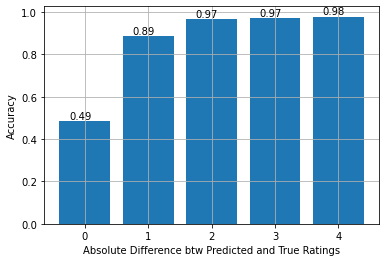

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(0,5), accumulated_accuracy[:5])
for i, v in enumerate(accumulated_accuracy[:5]):
    plt.text(i - 0.25, v + 0.01, str(round(v, 2)))
plt.xlabel("Absolute Difference btw Predicted and True Ratings")
plt.ylabel("Accuracy")
plt.grid()
plt.show()